In [ ]:
# Install the required libraries
#SAM
#! pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
#! pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
#! pip install datasets
#! pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
#! pip install patchify
#! pip install matplotlib
#! pip install tifffile
#! pip install scipy
#! pip install opencv-python


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


In [11]:

import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import glob
import cv2
from tqdm import tqdm

In [12]:
IMG_SIZE = 256

image_paths =  glob.glob("D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/train//images/*.tif")
masks_paths = glob.glob("D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/train/mask/*.tiff")

allImages = []
allMasks = []
for imgFile, imgMask, in tqdm(zip(image_paths, masks_paths), total=len(image_paths)):
  img = cv2. imread(imgFile)
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  img = img/255.0
  allImages.append(img)

  mask = cv2.imread(imgMask, cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
  mask[mask > 0] = 1
  allMasks.append(mask)



images = np.array(allImages)
masks = np.array(allMasks)
masks= masks.astype(np.uint8)
print(images.shape)
print(masks.shape)

100%|██████████| 216/216 [00:06<00:00, 31.12it/s]


(216, 256, 256, 3)
(216, 256, 256)


In [14]:
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray((img * 255).astype(np.uint8)) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

In [15]:
from datasets import Dataset
# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


dataset

c:\Users\fract\anaconda3\envs\worms\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['image', 'label'],
    num_rows: 216
})

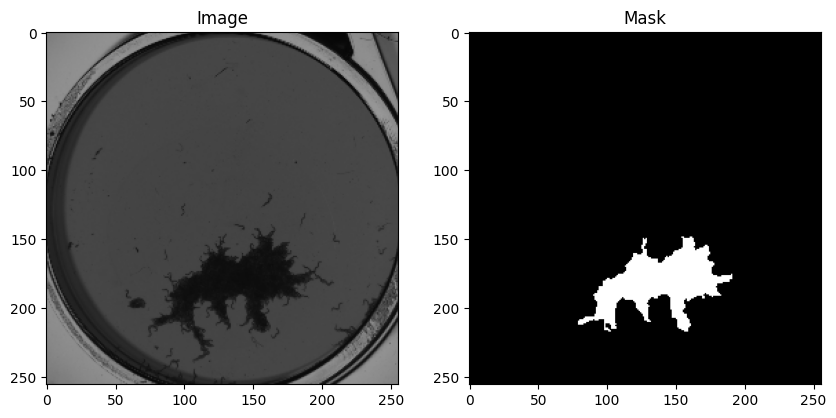

In [16]:
img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")
# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Display the images side by side
plt.show()

In [68]:
example_image.shape()

AttributeError: 'PngImageFile' object has no attribute 'shape'

In [17]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [18]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])
    
    # Convert the image to RGB format
    #image = image.convert("RGB") #This line was added to make sure images are read in expected format

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [19]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [20]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [21]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)


In [22]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


c:\Users\fract\anaconda3\envs\worms\Lib\site-packages\transformers\image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [23]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [24]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [26]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [42]:
! set CUDA_HOME=C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
! set PATH=%CUDA_HOME%\bin;%CUDA_HOME%\libnvvp;%PATH%

In [9]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)

GPUs Available: []


In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 938911069328143034
xla_global_id: -1
]


In [27]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/108 [00:00<?, ?it/s]c:\Users\fract\anaconda3\envs\worms\Lib\site-packages\transformers\image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
100%|██████████| 108/108 [06:04<00:00,  3.38s/it]


EPOCH: 0
Mean loss: 0.28077647196887817


100%|██████████| 108/108 [06:03<00:00,  3.37s/it]


EPOCH: 1
Mean loss: 0.16294018187801595


100%|██████████| 108/108 [06:03<00:00,  3.37s/it]


EPOCH: 2
Mean loss: 0.14137398099733722


100%|██████████| 108/108 [06:04<00:00,  3.38s/it]


EPOCH: 3
Mean loss: 0.13152219186088554


100%|██████████| 108/108 [06:05<00:00,  3.38s/it]


EPOCH: 4
Mean loss: 0.12232539617387508


100%|██████████| 108/108 [06:04<00:00,  3.37s/it]


EPOCH: 5
Mean loss: 0.11441676379008978


100%|██████████| 108/108 [06:04<00:00,  3.38s/it]


EPOCH: 6
Mean loss: 0.10976665418733049


100%|██████████| 108/108 [06:05<00:00,  3.38s/it]


EPOCH: 7
Mean loss: 0.10433707543200364


100%|██████████| 108/108 [06:04<00:00,  3.37s/it]


EPOCH: 8
Mean loss: 0.10213419172429929


100%|██████████| 108/108 [06:04<00:00,  3.38s/it]

EPOCH: 9
Mean loss: 0.09924268924320738


In [28]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/train//models/model_great_checkpoint.pth")

In [29]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/train//models/model_great_checkpoint.pth"))

<All keys matched successfully>

In [30]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

c:\Users\fract\anaconda3\envs\worms\Lib\site-packages\transformers\image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


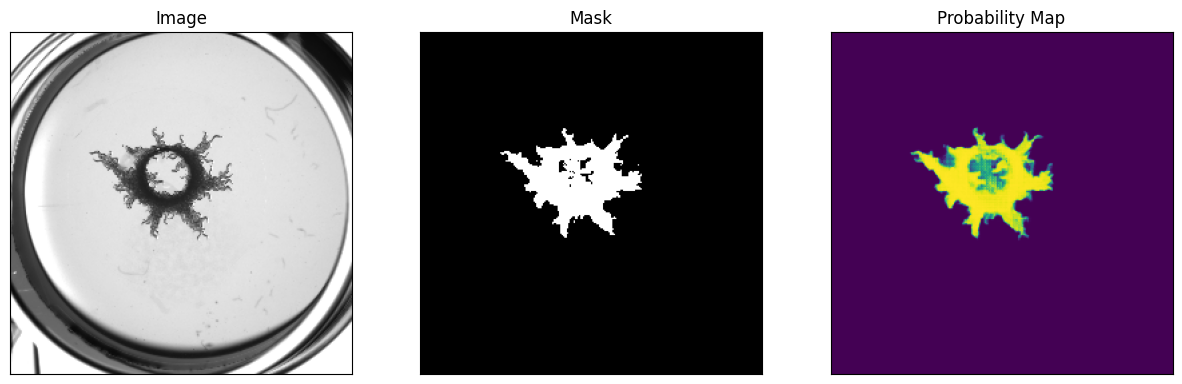

In [55]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]
#test_image = test_image.convert("RGB")

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
plt.subplot(1, 3, 1)
plt.imshow(np.array(test_image), cmap='gray')
plt.title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
# Display the images side by side
plt.show()

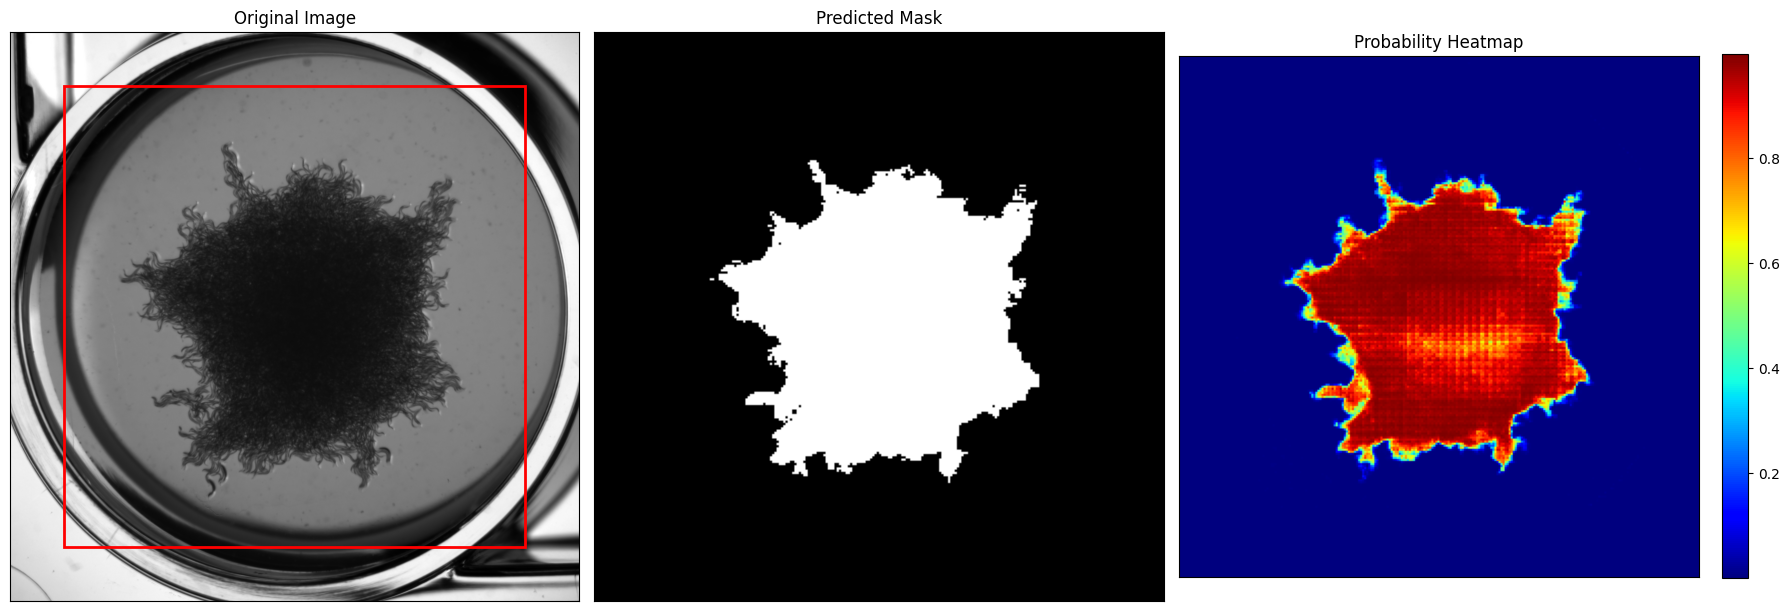

In [100]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Path to your new image
image_path = "D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/validation/images2/Test 6-22-24_Series001_t019_ch00.tif"

# Load and preprocess the image
def load_and_preprocess(image_path):
    # Read as grayscale but convert to RGB-like format for SAM
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Handle 16-bit TIFF normalization if needed
    if img.dtype == np.uint16:
        img = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))
    
    # Convert to 3-channel "RGB" by stacking grayscale channels
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img_rgb, img  # Return both RGB and original grayscale

# Load your image
test_image, original_grayscale = load_and_preprocess(image_path)

def auto_detect_prompt(gray_image, scale_factor=0.81):  # Reduce size depends on your image
    _, thresh = cv2.threshold(gray_image, 0, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        
        # Compute center of the bounding box
        center_x, center_y = x + w // 2, y + h // 2

        # Reduce the bounding box size
        new_w, new_h = int(w * scale_factor), int(h * scale_factor)

        # Compute new top-left and bottom-right coordinates
        new_x1 = max(center_x - new_w // 2, 0)
        new_y1 = max(center_y - new_h // 2, 0)
        new_x2 = min(center_x + new_w // 2, gray_image.shape[1])
        new_y2 = min(center_y + new_h // 2, gray_image.shape[0])

        return [new_x1, new_y1, new_x2, new_y2]
    else:
        h, w = gray_image.shape
        return [w//4, h//4, 3*w//4, 3*h//4]  # Default case

# Get automatic prompt (modify this logic based on your needs)
prompt = auto_detect_prompt(original_grayscale)

# Prepare inputs for SAM model
inputs = processor(
    Image.fromarray(test_image),  # Convert to PIL Image
    input_boxes=[[prompt]],       # Use detected bounding box
    return_tensors="pt"
).to(device)

# Run inference
my_mito_model.eval()
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# Process outputs
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg = (medsam_seg_prob > 0.5).float().cpu().numpy().squeeze()
medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()

# Visualization with bounding box overlay
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axes[0].imshow(original_grayscale, cmap='gray')
axes[0].set_title("Original Image")
axes[0].add_patch(plt.Rectangle((prompt[0], prompt[1]),
                              prompt[2]-prompt[0],
                              prompt[3]-prompt[1],
                              fill=False, edgecolor='red', linewidth=2))

# Predicted Mask
axes[1].imshow(medsam_seg, cmap='gray')
axes[1].set_title("Predicted Mask")

# Probability Map
prob_map = axes[2].imshow(medsam_seg_prob, cmap='jet')
plt.colorbar(prob_map, ax=axes[2], fraction=0.046, pad=0.04)
axes[2].set_title("Probability Heatmap")

# Formatting
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

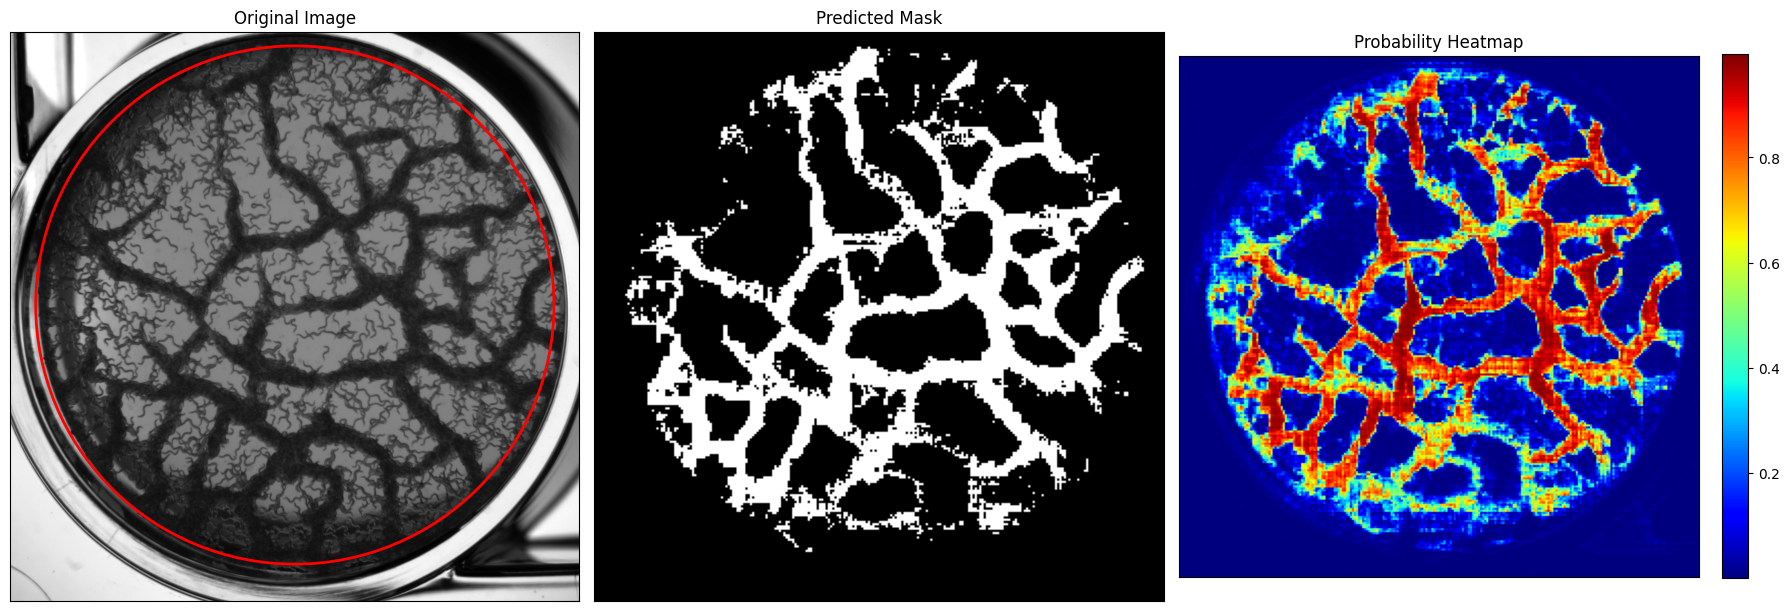

In [113]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Path to your new image
image_path = "D:/Gabriel_Lopez/project/segmentation/dataset/non-aug/validation/images2/Test 6-22-24_Series001_t322_ch00.tif"

# Load and preprocess the image
def load_and_preprocess(image_path):
    # Read as grayscale but convert to RGB-like format for SAM
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Handle 16-bit TIFF normalization if needed
    if img.dtype == np.uint16:
        img = cv2.convertScaleAbs(img, alpha=(255.0/65535.0))
    
    # Convert to 3-channel "RGB" by stacking grayscale channels
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img_rgb, img  # Return both RGB and original grayscale

# Load your image
test_image, original_grayscale = load_and_preprocess(image_path)

# Function to detect a circular bounding region
def auto_detect_prompt(gray_image, scale_factor=0.98, x_offset=0, y_offset=0):  
    _, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        c = max(contours, key=cv2.contourArea)
        (x, y), radius = cv2.minEnclosingCircle(c)  # Get enclosing circle
        
        # Apply manual shift
        return int(x) + x_offset, int(y) + y_offset, int(radius * scale_factor)
    else:
        # Default: center of image with estimated radius
        h, w = gray_image.shape
        return w // 2, h // 2, min(w, h) // 6  # Center with 1/4th image size

# Adjust these values to move the circle
x_shift = 120  # Move right (negative to move left)
y_shift = 100 # Move up (positive to move down)

# Get the adjusted circular prompt
cx, cy, r = auto_detect_prompt(original_grayscale, scale_factor=0.76, x_offset=x_shift, y_offset=y_shift)

# Prepare inputs for SAM model
inputs = processor(
    Image.fromarray(test_image),  # Convert to PIL Image
    input_boxes=[[[cx - r, cy - r, cx + r, cy + r]]],  # Convert circle to bounding box format
    return_tensors="pt"
).to(device)

# Run inference
my_mito_model.eval()
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# Process outputs
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
medsam_seg = (medsam_seg_prob > 0.45).float().cpu().numpy().squeeze()
medsam_seg_prob = medsam_seg_prob.detach().cpu().numpy().squeeze()

# Visualization with circular bounding region
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axes[0].imshow(original_grayscale, cmap='gray')
axes[0].set_title("Original Image")

# Draw circle instead of rectangle
circle = plt.Circle((cx, cy), r, color='red', fill=False, linewidth=2)
axes[0].add_patch(circle)

# Predicted Mask
axes[1].imshow(medsam_seg, cmap='gray')
axes[1].set_title("Predicted Mask")

# Probability Map
prob_map = axes[2].imshow(medsam_seg_prob, cmap='jet')
plt.colorbar(prob_map, ax=axes[2], fraction=0.046, pad=0.04)
axes[2].set_title("Probability Heatmap")

# Formatting
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [60]:
import numpy as np

# Assuming medsam_seg_prob is your probability heatmap
# Define the probability range I am interested in
lower_prob = 0.5  # Example lower bound
upper_prob = 1.0  # Example upper bound

# Create a binary mask for the specified probability range
prob_mask = (medsam_seg_prob >= lower_prob) & (medsam_seg_prob <= upper_prob)

# Calculate the area by counting the pixels in the mask
area_pixels = np.sum(prob_mask)

# If you know the area each pixel represents (e.g., in square meters), you can calculate the total area
pixel_area = 1.0  # Replace with the actual area per pixel (e.g., in square meters)
total_area = area_pixels * pixel_area

print(f"Area of probability range [{lower_prob}, {upper_prob}]: {total_area} square units")

Area of probability range [0.5, 1.0]: 13653.0 square units


In [66]:
area_pixels.shape

()